# Exploring HTCondor test run results

In [1]:
# reload modules before executing code in order to make development and debugging easier
%load_ext autoreload
%autoreload 2

In [2]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir, basename, isfile
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import analysis as an

# Results directories

In [4]:
# path to the parent condor directory for this run
main_dir = "output/htcondor_runs/condor_energize_2021-03-29_15-24-17_test_run_new_terms"
# condor log dir contains the condor .out, .err, and .log files for every job
condor_log_dir = join(main_dir, "output", "condor_logs")
# the energize out dir contains the output folder for every job
# each job's output folder has energies.csv and other output files
energize_out_dir = join(main_dir, "output", "energize_outputs")

# Check for failed jobs

In [5]:
# failed_jobs means no energies.csv
# missing_jobs means no output directory at all
failed_jobs = an.check_for_failed_jobs(energize_out_dir)
missing_jobs = an.check_for_missing_jobs(main_dir, energize_out_dir)

print("Failed jobs: {}, Missing jobs: {}".format(len(failed_jobs), len(missing_jobs)))

Failed jobs: 0, Missing jobs: 0


# Resource usage
Requested CPUs = 1, Requested Disk = 10 GB, Requested RAM = 2 GB

In [6]:
resources = an.resource_usage(condor_log_dir)
print(resources)

     job_num  cpus     disk  memory
0          0  1.00  7564328     900
1          1  0.99  7564300     905
2          2  1.00  7564330     911
3          3  1.00  7564322     433
4          4  0.84  7564328     936
..       ...   ...      ...     ...
995      995  1.00  7564373     354
996      996  0.95  7564611     431
997      997  1.07  7564376     958
998      998  1.00  7564398     354
999      999  0.74  7564394     432

[1000 rows x 4 columns]


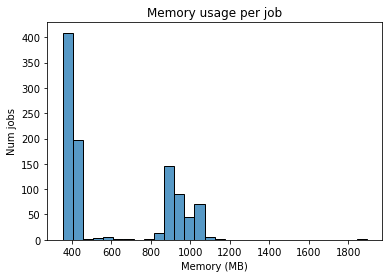

In [7]:
fig, ax = plt.subplots(1)
sns.histplot(data=resources, x="memory", ax=ax, bins=30)
ax.set(title="Memory usage per job", xlabel="Memory (MB)", ylabel="Num jobs")
plt.show()
plt.close(fig)

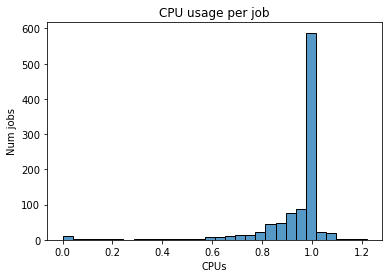

In [8]:
fig, ax = plt.subplots(1)
sns.histplot(data=resources, x="cpus", ax=ax, bins=30)
ax.set(title="CPU usage per job", xlabel="CPUs", ylabel="Num jobs")
plt.show()
plt.close(fig)

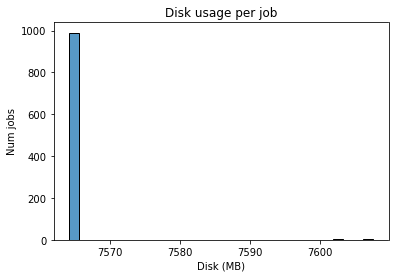

In [9]:
fig, ax = plt.subplots(1)
sns.histplot(x=resources["disk"]/1000, ax=ax, bins=30)
ax.set(title="Disk usage per job", xlabel="Disk (MB)", ylabel="Num jobs")
plt.show()
plt.close(fig)

# Runtimes

In [10]:
energies = an.load_energies(energize_out_dir)
energies.head()

,pdb_fn,variant,job_uuid,start_time,run_time,total_score,dslf_fa13,fa_atr,fa_dun,fa_elec,...,env,hs_pair,linear_chainbreak,overlap_chainbreak,pair,rg,rsigma,sheet,ss_pair,vdw
0,2qmt_p.pdb,"G9E,T18M",XrA5rSP33Gk9,2021-03-29 20:56:27,147,-207.399,0.0,-327.512,69.187,-135.900,...,-18.232,-3.946,0.0,0.0,-0.819,33.590,-23.564,0.343,-34.177,0.000
1,2qmt_p.pdb,"V21L,A34G",XrA5rSP33Gk9,2021-03-29 21:16:08,134,-217.916,0.0,-317.299,63.210,-145.152,...,-20.408,-4.367,0.0,0.0,3.148,33.442,-22.216,0.343,-31.947,0.000
2,2qmt_p.pdb,"K4R,L5H",XrA5rSP33Gk9,2021-03-29 22:42:24,166,-211.961,0.0,-330.647,70.221,-145.733,...,-18.368,-4.183,0.0,0.0,1.107,33.408,-21.206,0.343,-33.064,0.403
3,2qmt_p.pdb,"I6G,K28T",XrA5rSP33Gk9,2021-03-29 22:03:06,151,-205.409,0.0,-318.634,68.965,-146.752,...,-19.225,-4.275,0.0,0.0,-2.361,33.082,-19.380,0.343,-31.052,0.000
4,2qmt_p.pdb,"K13N,V54Y",XrA5rSP33Gk9,2021-03-29 22:37:27,146,-202.022,0.0,-315.978,68.329,-143.116,...,-18.874,-3.133,0.0,0.0,2.821,33.531,-23.074,0.343,-33.263,0.000


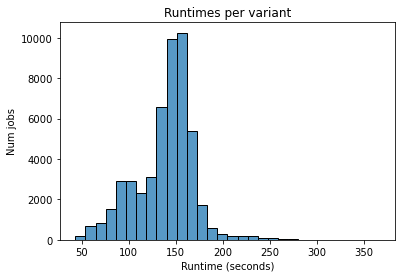

In [11]:
fig, ax = plt.subplots(1)
sns.histplot(data=energies, x="run_time", ax=ax, bins=30)
ax.set(title="Runtimes per variant", xlabel="Runtime (seconds)", ylabel="Num jobs")
plt.show()
plt.close(fig)

In [12]:
print("Avg runtime: {:.2f} seconds".format(energies["run_time"].mean()))

Avg runtime: 138.63 seconds


## Runtime distribution per job
The jobs that processed double mutants got a random sample of 50 double mutants. Did some jobs process their random sample faster because they ran on a faster server? Probably.

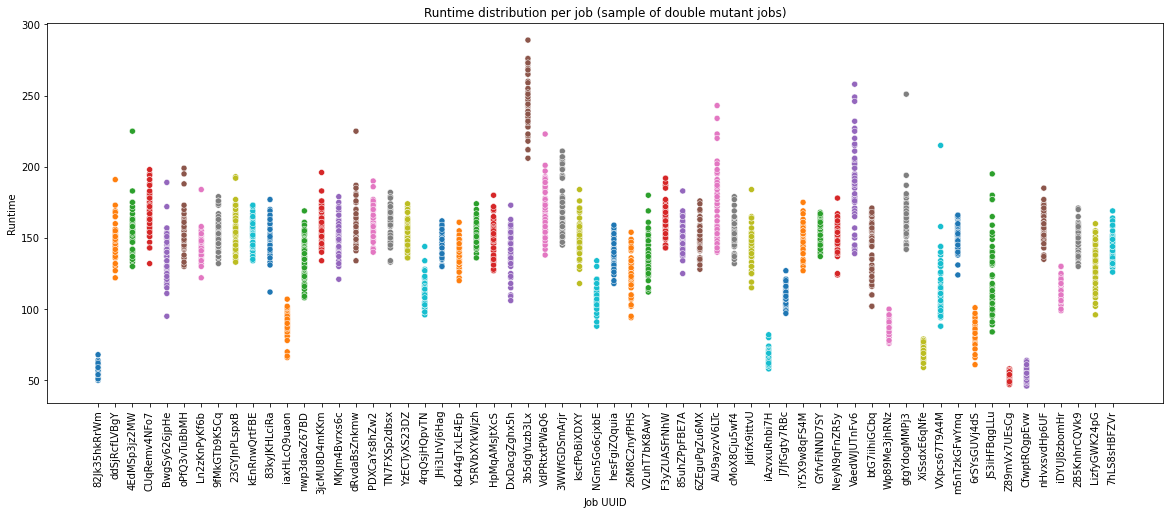

In [13]:
fig, ax = plt.subplots(1, figsize=(20, 7))
# the first 1000 are all single mutants *in order*
start_idx = 2000
max_idx = 5000
sns.scatterplot(x=energies.job_uuid[start_idx:max_idx], y=energies.run_time[start_idx:max_idx], hue=energies.job_uuid[start_idx:max_idx], palette="tab10", ax=ax)
ax.set(title="Runtime distribution per job (sample of double mutant jobs)", xlabel="Job UUID", ylabel="Runtime")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xticks(rotation=90)
ax.get_legend().remove()
plt.show()
plt.close(fig)

# Energies
Explore the energies...

In [14]:
energies.columns

Index(['pdb_fn', 'variant', 'job_uuid', 'start_time', 'run_time',
       'total_score', 'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec',
       'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'lk_ball_wtd',
       'omega', 'p_aa_pp', 'pro_close', 'rama_prepro', 'ref', 'yhh_planarity',
       'filter_total_score', 'buried_all', 'buried_np', 'contact_all',
       'contact_buried_core', 'contact_buried_core_boundary', 'degree',
       'degree_core', 'degree_core_boundary', 'exposed_hydrophobics',
       'exposed_np_AFIMLWVY', 'exposed_polars', 'exposed_total',
       'one_core_each', 'pack', 'res_count_all', 'res_count_buried_core',
       'res_count_buried_core_boundary', 'res_count_buried_np_core',
       'res_count_buried_np_core_boundary', 'ss_contributes_core', 'ss_mis',
       'total_hydrophobic', 'total_hydrophobic_AFILMVWY', 'total_sasa',
       'two_core_each', 'unsat_hbond', 'centroid_total_score', 'cbeta',
  

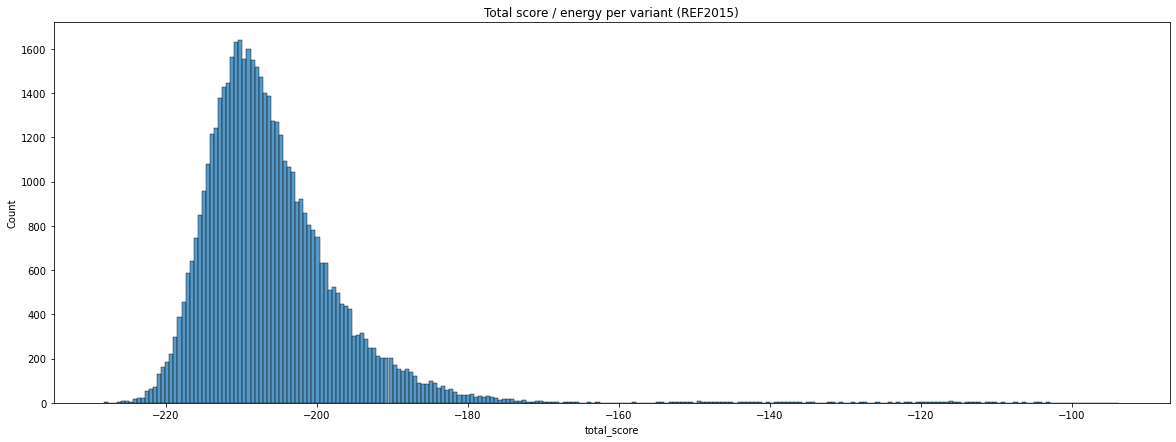

In [15]:
fig, ax = plt.subplots(1, figsize=(20, 7))
sns.histplot(data=energies, x="total_score", ax=ax)
ax.set(title="Total score / energy per variant (REF2015)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
plt.close(fig)

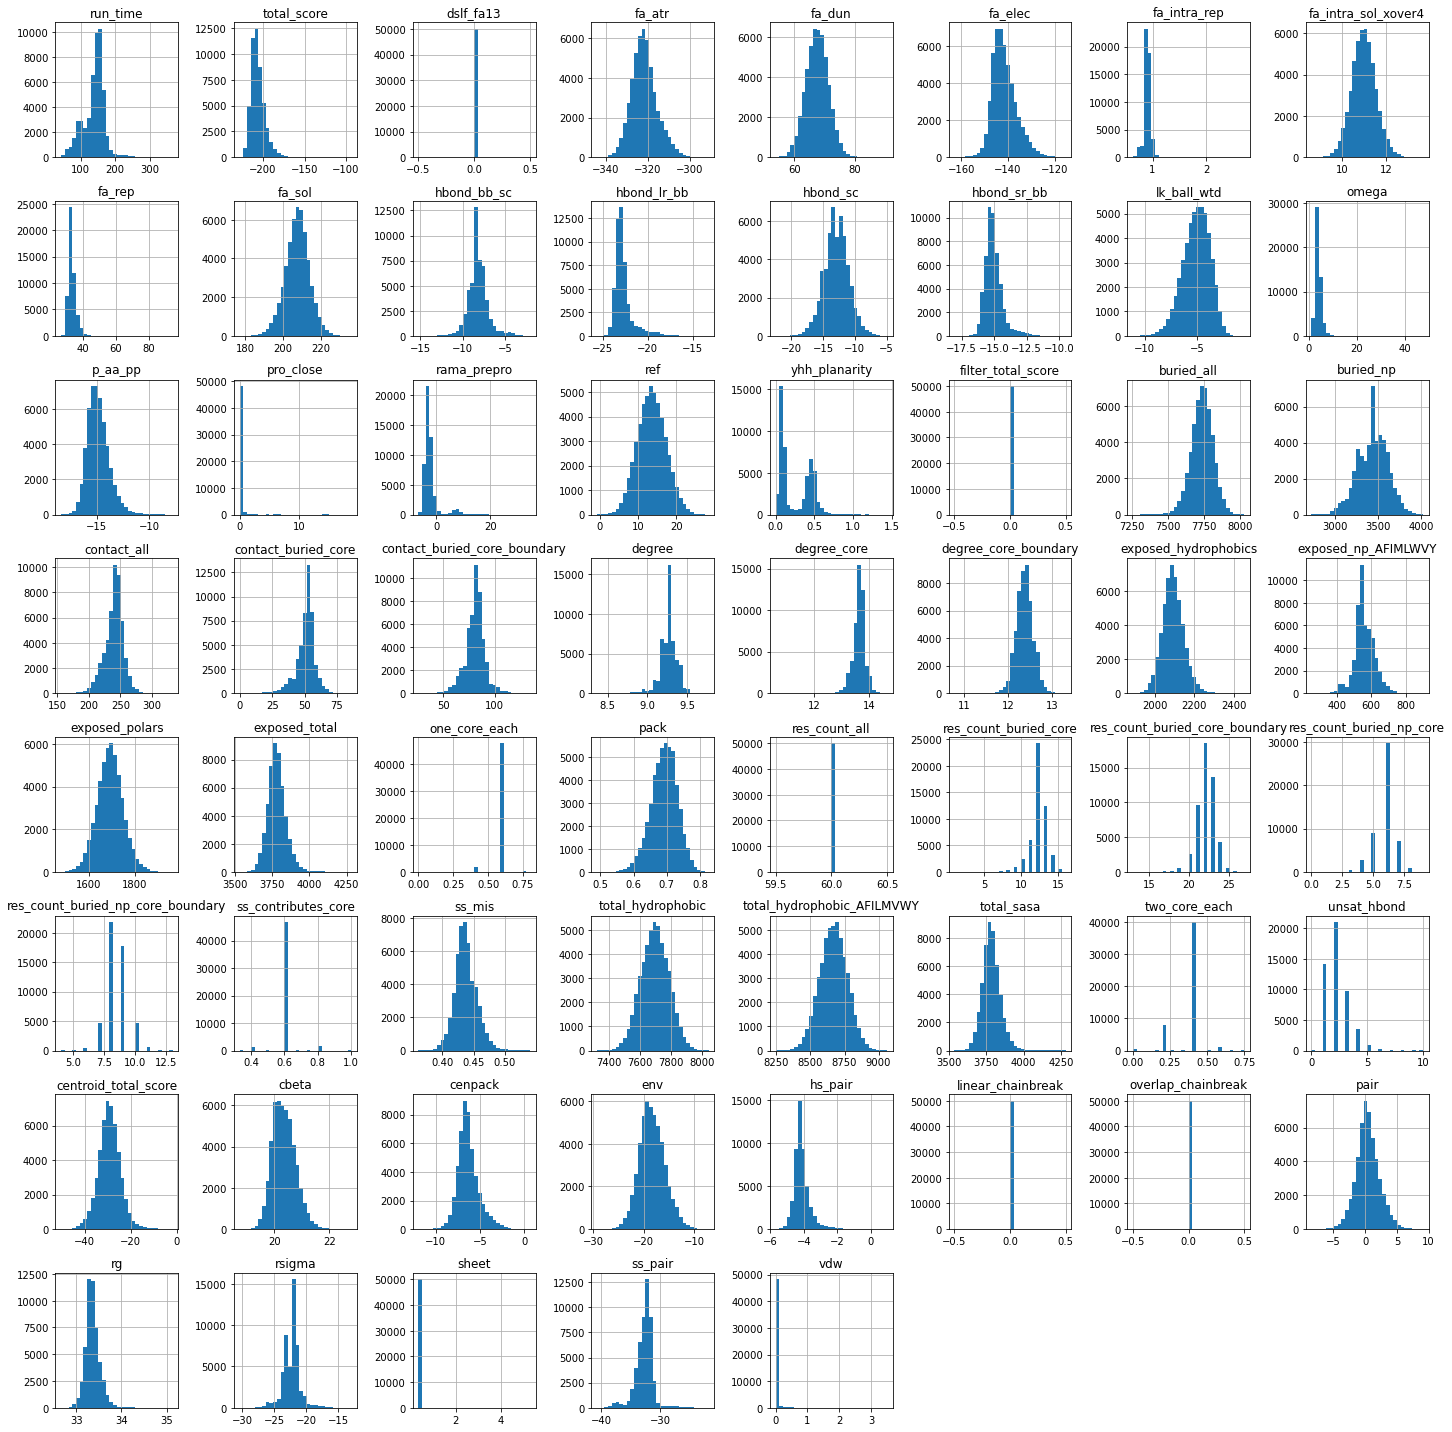

In [16]:
axes = energies.hist(bins=30, figsize=(20, 20))
plt.tight_layout()
plt.show()
plt.close(axes[0][0].get_figure())